In [2]:

import matplotlib.colors as mcolors
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

/home/mphatsosimbao/.local/lib/python3.12/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


In [3]:
# plt.rcParams.update({"font.family": "Roboto Condensed"})

# path = "https://raw.githubusercontent.com/rfordatascience/tidytuesday/master/data/2021/2021-01-26/plastics.csv"
# data = pd.read_csv(path)
# data.to_csv('plastics.csv')

path = "plastics.csv"
data = pd.read_csv(path)

types_of_plastic = ["empty", "hdpe", "ldpe", "o", "pet", "pp", "ps", "pvc"]
total_by_company = (
    data
    .groupby(["parent_company", "year"], dropna=True)[types_of_plastic]
    .sum()
    .reset_index()
)
total_by_company

,parent_company,year,empty,hdpe,ldpe,o,pet,pp,ps,pvc
0,"""ESE""",2019,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,"""Inko"" noodles / Ð®Ñ„ÐºÐ° â€œÐ˜Ð½ÐºÐ¾""",2019,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,"""Мелочи Жизни"" (Ооо Ергопак)",2019,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0
3,#ERROR!,2020,0.0,0.0,0.0,20.0,0.0,0.0,0.0,0.0
4,(Local Factory),2020,0.0,0.0,0.0,0.0,9.0,20.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...
11215,Ямуна,2019,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0
11216,Янтар,2019,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0
11217,Янтар (Сан Інбев Україна),2019,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0
11218,Янтарь,2019,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


In [4]:

def get_top_n_data(data, n):
    """Create data frame with plastic values for the top-n companies and one Others group."""

    # Analyses data from 2020 only
    # Compute the total plastic waste per company
    top_data = (
        data
        .query("year == 2020")
        .melt(
            id_vars=["parent_company", "year"], 
            value_vars=types_of_plastic, 
            var_name="type"
        )
        .groupby("parent_company")["value"]
        .sum()
        .reset_index()
    )

    # Use "Unbranded_unknown" for unbranded/unknown/error cases
    top_data["parent_company"] = np.where(
        top_data["parent_company"].isin(["Unbranded", "null", "NULL", "#ERROR!"]), 
        "Unbranded_unknown",
        top_data["parent_company"]
    )

    # Create a list of top companies.
    # This list contains the top n companies with largest plastic waste.
    top_companies = list(top_data.sort_values("value", ascending=False)["parent_company"][:n])

    # Create a lumped version of the company variable. 
    # If "parent_company" is one of the top companies, it gets its original name. 
    # Otherwise, it's labelled with "Other"
    top_data["company_lumped"] = np.where(
        top_data["parent_company"].isin(top_companies),
        top_data["parent_company"],
        "Other"
    )

    # Merge `top_data` with `total_by_company`
    top_data = top_data.drop_duplicates(["parent_company", "company_lumped"])
    top_data = top_data.merge(total_by_company, on="parent_company")

    # Sum all types of plastic except from 'empty' into the "total" variable
    top_data["total"] = top_data.loc[:, types_of_plastic[1:]].sum(axis=1)

    return top_data


#=======================================================================


top_thirty = get_top_n_data(total_by_company, n=30)

# For each company, compute the total waste per each type of plastic
top_thirty = (
    top_thirty
    .groupby("company_lumped")[types_of_plastic]
    .sum()
    .reset_index()
)

# Add a column with the sum of the plastic waste for all types of plastic
top_thirty["row_sum"] = top_thirty.loc[:, types_of_plastic].sum(axis=1)

# Divide the waste of each type of plastic by the total waste to get the proportion of waste for
# each type of plastic
top_thirty[types_of_plastic] = top_thirty[types_of_plastic].apply(lambda x: x / top_thirty["row_sum"])

# Unpivot data
top_thirty = top_thirty.melt(
    id_vars="company_lumped",  
    value_vars=types_of_plastic,
    var_name="type",
    value_name="proportion"
)

print(top_thirty)

                   company_lumped   type  proportion
0                  Bakhresa Group  empty    0.000000
1            Blow-Chem Industries  empty    0.000000
2                       Britannia  empty    0.000000
3               Colgate-Palmolive  empty    0.000611
4                      Cway Group  empty    0.000000
..                            ...    ...         ...
235                      Unilever    pvc    0.002212
236  Universal Robina Corporation    pvc    0.005780
237          Voltic Ghana Limited    pvc    0.000000
238            W.L. Food Products    pvc    0.000000
239                       jasmine    pvc    0.000000

[240 rows x 3 columns]


In [5]:
# Get company names
categories = list(top_thirty["company_lumped"].unique())
# Sort categories according to their lowercase version (this step is important!)
sorted_categories = sorted(categories, key=str.lower)
# Remove "Other" from the list and append it to the tail
sorted_categories.remove("Other")
sorted_categories.append("Other")


In [6]:
top_thirty["company_lumped"] = pd.Categorical(
    top_thirty["company_lumped"], 
    categories=sorted_categories, 
    ordered=True
)

# Finally, sort the values in the data frame according to this custom sort.
top_thirty = top_thirty.sort_values("company_lumped", ascending=False)



In [7]:
# Define colors
COLORS = ["#0C2C84", "#225EA8", "#1D91C0", "#41B6C4", "#7FCDBB", "#C7E9B4", "#FFFFCC"]
# Create colormap
cmap = mcolors.LinearSegmentedColormap.from_list("colormap", COLORS, N=256)


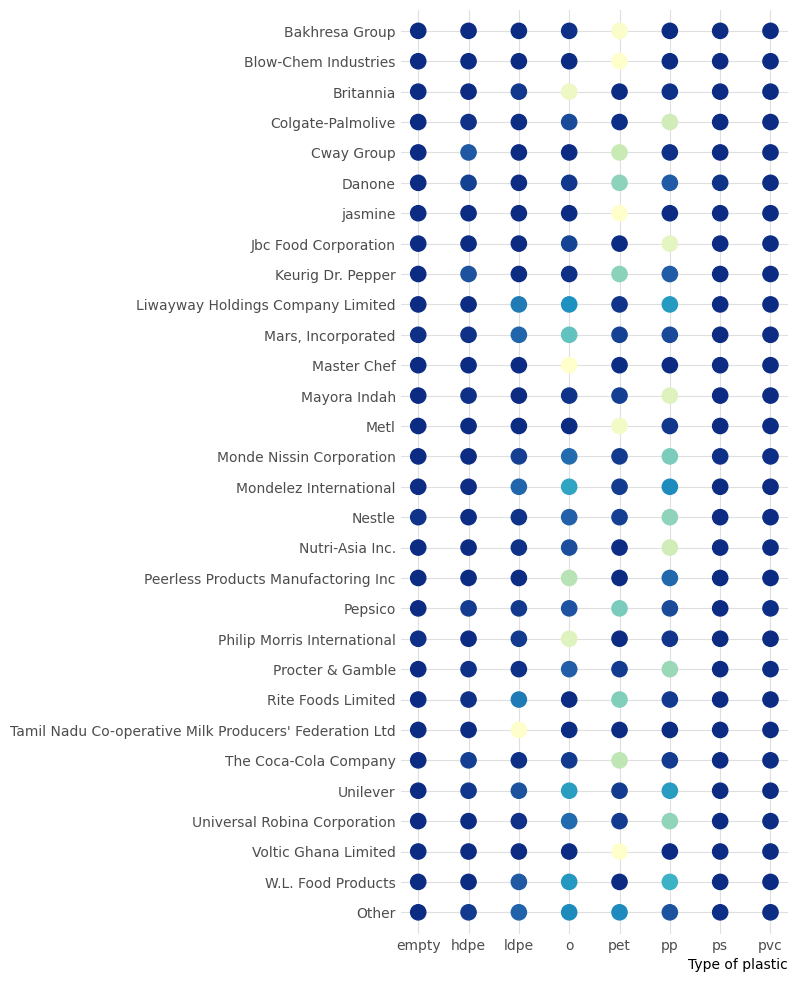

In [8]:

def plot_heatmap(ax):
    # Iterate over types of plastic
    for i, plastic in enumerate(types_of_plastic):
        # Select data for the given type of plastic
        d = top_thirty[top_thirty["type"] == plastic]

        # Get values for the x and y axes
        y = d["company_lumped"]
        x = [i] * len(y)
        
        # Generate colors. No need to normalize since proportions are between 0 and 1.
        color = cmap(d["proportion"]) 
        
        # Plot the markers for the selected company
        ax.scatter(x, y, color=color, s=120)

    # Remove all spines
    ax.set_frame_on(False)

    # Set grid lines with some transparency
    ax.grid(alpha=0.4)

    # Make sure grid lines are behind other objects
    ax.set_axisbelow(True)

    # Set position for x ticks
    ax.set_xticks(np.arange(len(types_of_plastic)))

    # Set labels for the x ticks (the names of the types of plastic)
    ax.set_xticklabels(types_of_plastic)

    # Remove tick marks by setting their size to 0. Set text color to "0.3" (a type of grey)
    ax.tick_params(size=0, colors="0.3")

    # Set label for horizontal axis.
    ax.set_xlabel("Type of plastic", loc="right")

    # Default vertical limits are shrunken by 0.75
    y_shrunk = 0.75
    y_lower, y_upper = ax.get_ylim()
    ax.set_ylim(y_lower + y_shrunk, y_upper - y_shrunk)
    
    return ax

#=======================================================================

fig, ax = plt.subplots(figsize=(5, 12))
plot_heatmap(ax);
plt.show()